<a href="https://colab.research.google.com/github/FranziskoB/Challenge-Data-Science-Alura-2ed/blob/main/Semana_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Desafio Data Science Alura

A imobiliária InsightPlaces, situada na cidade do Rio de Janeiro, está enfrentando dificuldades para alugar e vender imóveis. Em uma pesquisa de como empresas semelhantes operam no mercado, a InsightPlaces percebeu que esse problema pode estar relacionado aos valores dos imóveis e às recomendações realizadas em seu site.

Dentro desse contexto, como podemos definir de forma eficiente os preços dos imóveis lidando com grandes volumes de dados? É importante recomendar imóveis utilizando outro critério? O que precisa ser feito?

Você faz parte do time de Ciência de Dados e Big Data da InsightPlaces e ficou responsável por auxiliar no processo de análise de dados dos imóveis, que estão localizados em alguns bairros da cidade do Rio de Janeiro.

Esse projeto tem algumas etapas como: ler e fazer o tratamento do histórico dos preços de imóveis no Rio de Janeiro, construir um modelo de regressão para precificar imóveis e, por último, criar um recomendador de imóveis. Para cada uma dessas etapas, vamos utilizar a ferramenta PySpark, que oferece uma melhor performance ao trabalharmos com grandes volumes de dados.

##Semana 2

Tratamento dos dados e criação de um modelo de regressão com PySpark

### Configurando o Spark no Google Colab

In [1]:
# instalar as dependências
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()

#### Acessando o Spark UI (Google Colab)n

Uma SparkSession pode ser utilizada para criar DataFrames, registrar DataFrames como tabelas, executar consultas SQL em tabelas, armazenar em cache e ler arquivos parquet.

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Iniciando com Spark") \
    .config('spark.ui.port', '4050') \
    .getOrCreate()

In [5]:
!wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [6]:
get_ipython().system_raw('./ngrok http 4050 &')

In [7]:
!curl -s http://localhost:4040/api/tunnels

{"tunnels":[],"uri":"/api/tunnels"}


### Carregamento de dados

Descrição de cada variável do dataset
*   id ->	Código de identificação do anúncio no sistema da InsightPlaces
*   tipo_unidade ->	Tipo de imóvel (apartamento, casa e outros)
*   tipo_uso ->	Tipo de uso do imóvel (residencial ou comercial)
*   area_total ->	Área total do imóvel (construção e terreno)
*   area_util ->	Área construída do imóvel
*   quartos ->	Quantidade de quartos do imóvel
*   suites ->	Quantidade de suítes do imóvel
*   banheiros ->	Quantidade de banheiros do imóvel
*   vaga ->	Quantidade de vagas de garagem do imóvel
*   caracteristicas ->	Listagem de características do imóvel
*   andar ->	Número do andar do imóvel
*   endereco ->	Informações sobre o endereço do imóvel
*   valores ->	Informações sobre valores de venda e locação dos imóveis




In [8]:
import zipfile
import requests
from io import BytesIO
import os

In [9]:
os.makedirs("./dados",exist_ok=True) # Criando uma pasta no google colab

In [10]:
path = 'https://github.com/FranziskoB/Challenge-Data-Science-Alura-2ed/raw/main/dados/semana-2.zip' # Local do arquivo zip
filebytes = BytesIO(
    requests.get(path).content
)
myzip = zipfile.ZipFile(filebytes)
myzip.extractall("./dados") #Salvando os dados na pasta criada

In [11]:
dados = spark.read.parquet("/content/dados/dataset_transformado_parquet") # Importando os dados

In [12]:
dados.count() # Número de registros carregados

66562

### Visualizando os dados

Os primeiro 5 valores


In [13]:
dados.show(5)
dados.printSchema()

+--------------------+-----+----------+---------+---------+--------------------+-------+------+------------+------------+-----------+----+------------+------------+----------+----+-----+------+
|                  id|andar|area_total|area_util|banheiros|     caracteristicas|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|      bairro|        zona|condominio|iptu| tipo| valor|
+--------------------+-----+----------+---------+---------+--------------------+-------+------+------------+------------+-----------+----+------------+------------+----------+----+-----+------+
|03a386b6-7ab8-4ef...|    0|        43|       43|        1|[Churrasqueira, A...|      2|  null|       Usado| Apartamento|Residencial|   1|    Realengo|  Zona Oeste|       285|null|Venda| 22999|
|1fe78d41-b8e0-4d2...|    0|        44|       44|        1|                  []|      2|     0|       Usado| Apartamento|Residencial|   0|       Irajá|  Zona Norte|       170|   0|Venda|110000|
|1fa1c1e5-e98c-433...|    4|  

### Tratando os dados

Convertendo colunas para integer e double

In [14]:
from pyspark.sql.types import IntegerType, DoubleType
dados=dados\
    .withColumn('iptu', dados['iptu'].cast(DoubleType()))\
    .withColumn('valor', dados['valor'].cast(DoubleType()))\
    .withColumn('condominio', dados['condominio'].cast(IntegerType()))\
    .withColumn('area_total', dados['area_total'].cast(DoubleType()))\
    .withColumn('area_util', dados['area_util'].cast(DoubleType()))\
    .withColumn('vaga', dados['vaga'].cast(IntegerType()))\
    .withColumn('andar', dados['andar'].cast(IntegerType()))\
    .withColumn('banheiros', dados['banheiros'].cast(IntegerType()))\
    .withColumn('suites', dados['suites'].cast(IntegerType()))\
    .withColumn('quartos', dados['quartos'].cast(IntegerType()))

Transformando os dados da coluna caracteristicas com lista vazia em null

In [15]:
#from pyspark.sql.functions import when
#from pyspark.sql.functions import col, concat_ws
#dados.withColumn('caracteristicas',when(dados['caracteristicas'][0].isNull(),dados['caracteristicas'][0]).otherwise(concat_ws(",",col("caracteristicas")))).show(truncate=False)

### Seleção de features

Vamos analisar e retirar variáveis que não podem contribuir para a criação dos modelos de ML

In [16]:
dados\
    .select('tipo_anuncio')\
    .groupBy('tipo_anuncio')\
    .count()\
    .show()

dados\
    .select('tipo_uso')\
    .groupBy('tipo_uso')\
    .count()\
    .show()

dados\
    .select('tipo_unidade')\
    .groupBy('tipo_unidade')\
    .count()\
    .show()
dados\
    .select('tipo')\
    .groupBy('tipo')\
    .count()\
    .show()

+------------+-----+
|tipo_anuncio|count|
+------------+-----+
|       Usado|66562|
+------------+-----+

+-----------+-----+
|   tipo_uso|count|
+-----------+-----+
|Residencial|66562|
+-----------+-----+

+------------+-----+
|tipo_unidade|count|
+------------+-----+
| Apartamento|66562|
+------------+-----+

+-----+-----+
| tipo|count|
+-----+-----+
|Venda|66562|
+-----+-----+



Vamos retirar as variáveis acima por terem valor único

In [17]:
dados=dados\
      .drop('tipo_unidade')\
      .drop('tipo_anuncio')\
      .drop('tipo_uso')\
      .drop('tipo')\
      .drop('area_total')
      #area_total apresenta informação redundante em relação a area_util e há valores nulos então também será retirado

### Tratamento da coluna caracteristicas

Pode-se extrair variáveis dummy dessa coluna

Vamos analisar quais tipos de características estão na base

In [18]:
from pyspark.sql.functions import explode
dados.select(dados.id,explode(dados.caracteristicas))\
      .select("col")\
      .distinct()\
      .show()

+------------------+
|               col|
+------------------+
|Condomínio fechado|
|        Playground|
| Portão eletrônico|
|           Piscina|
|Animais permitidos|
|      Portaria 24h|
|          Elevador|
|          Academia|
|   Salão de festas|
|     Churrasqueira|
+------------------+



Vamos realizar um explode dos dados de caracteríticas usando como referência a coluna ID

In [19]:
dados_ex=dados.select(dados.id,explode(dados.caracteristicas))
dados_ex.show(truncate=False)

+------------------------------------+------------------+
|id                                  |col               |
+------------------------------------+------------------+
|03a386b6-7ab8-4eff-891d-f8a16efc1989|Churrasqueira     |
|03a386b6-7ab8-4eff-891d-f8a16efc1989|Academia          |
|03a386b6-7ab8-4eff-891d-f8a16efc1989|Playground        |
|03a386b6-7ab8-4eff-891d-f8a16efc1989|Salão de festas   |
|03a386b6-7ab8-4eff-891d-f8a16efc1989|Condomínio fechado|
|03a386b6-7ab8-4eff-891d-f8a16efc1989|Portão eletrônico |
|03a386b6-7ab8-4eff-891d-f8a16efc1989|Portaria 24h      |
|03a386b6-7ab8-4eff-891d-f8a16efc1989|Animais permitidos|
|40a2cbde-946b-42da-b7f2-b80057c7a47f|Condomínio fechado|
|40a2cbde-946b-42da-b7f2-b80057c7a47f|Portaria 24h      |
|40a2cbde-946b-42da-b7f2-b80057c7a47f|Salão de festas   |
|40a2cbde-946b-42da-b7f2-b80057c7a47f|Churrasqueira     |
|40a2cbde-946b-42da-b7f2-b80057c7a47f|Piscina           |
|40a2cbde-946b-42da-b7f2-b80057c7a47f|Animais permitidos|
|be269ddf-a4a3

Extraindo variáveis Dummy do dados acima e agrupando pela variável id

In [20]:
from pyspark.sql import functions as f
dados_ex=dados_ex.groupBy("id")\
        .pivot('col')\
        .agg(f.lit(1))\
        .na\
        .fill(0)
dados_ex.show(truncate=False)

+------------------------------------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|id                                  |Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+------------------------------------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|fd96bbd5-d631-416a-9f84-29091cefe14c|1       |1                 |1            |1                 |1       |1      |1         |1           |1                |1              |
|bfffedfe-99e7-4aed-9a9f-f766225a0f1f|0       |1                 |1            |1                 |1       |0      |1         |0           |1                |1              |
|fcb67af3-5601-415f-9d1f-75280923a4e3|1       |1                 |1            |0                 |0       |1      |1        

Inserindo as colunas no dataset e excluindo a coluna caracteristicas

In [21]:
dados=dados\
    .join(dados_ex, 'id', how='left').drop('caracteristicas')
dados.show(truncate=False)

+------------------------------------+-----+---------+---------+-------+------+----+-----------------------+------------+----------+------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|id                                  |andar|area_util|banheiros|quartos|suites|vaga|bairro                 |zona        |condominio|iptu  |valor   |Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+------------------------------------+-----+---------+---------+-------+------+----+-----------------------+------------+----------+------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|03a386b6-7ab8-4eff-891d-f8a16efc1989|0    |43.0     |1        |2      |null  |1   |Realengo               |Zona Oeste  |285       |null  |22999.

###Tratando dados nulos e NaN's

contando dados nulos e NaN's

In [22]:
dados\
    .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dados.columns])\
    .show()

+---+-----+---------+---------+-------+------+----+------+----+----------+----+-----+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
| id|andar|area_util|banheiros|quartos|suites|vaga|bairro|zona|condominio|iptu|valor|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+---+-----+---------+---------+-------+------+----+------+----+----------+----+-----+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|  0|    0|        0|        0|      0|  5554|3017|     0|   0|      2371|7199|    0|   12736|             12736|        12736|             12736|   12736|  12736|     12736|       12736|            12736|          12736|
+---+-----+---------+---------+-------+------+----+------+----+----------+----+-----+--------+------------------

Substituindo valores nulos por zero

In [23]:
dados=dados\
    .select('*')\
    .na\
    .fill(0)


###Preparação dos dados para machine learning

In [24]:
dados\
    .select('zona')\
    .groupBy('zona')\
    .count()\
    .show()
dados\
    .select('bairro')\
    .groupBy('bairro')\
    .count()\
    .show()

+------------+-----+
|        zona|count|
+------------+-----+
|  Zona Norte|11897|
|  Zona Oeste|32979|
|Zona Central| 1144|
|    Zona Sul|20531|
|            |   11|
+------------+-----+

+-------------------+-----+
|             bairro|count|
+-------------------+-----+
|             Cocotá|   16|
|       Tomás Coelho|   38|
|              Gávea|  597|
|            Ipanema| 2113|
|           Realengo|   46|
|      Gardênia Azul|    7|
|      Bento Ribeiro|   33|
|              Rocha|   38|
|Vicente de Carvalho|   86|
|         Manguinhos|    1|
|       Campo Grande|  639|
|        Jacarepaguá| 4437|
|               Leme|  234|
|           Botafogo| 3499|
|       Padre Miguel|   15|
|       Santo Cristo|  357|
|           Flamengo| 1378|
|  Engenho da Rainha|   25|
| Pedra de Guaratiba|   12|
|            Piedade|  104|
+-------------------+-----+
only showing top 20 rows



A zona é uma coluna que é interessante extrair colunas categóricas mas o bairro não pois apresenta muitas variáveis

In [25]:
dados = dados\
    .where(f.col('zona') != '')#Tirando linhas sem zona
dados=dados.drop('bairro') #Tirando o bairro do dataset
zona = dados\
    .groupBy('ID')\
    .pivot('zona')\
    .agg(f.lit(1))\
    .na\
    .fill(0)

In [26]:
dados = dados\
    .join(zona, 'ID', how='inner')
dados.show(truncate=False)

+------------------------------------+-----+---------+---------+-------+------+----+----------+----------+-------+---------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+------------+----------+----------+--------+
|id                                  |andar|area_util|banheiros|quartos|suites|vaga|zona      |condominio|iptu   |valor    |Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+------------------------------------+-----+---------+---------+-------+------+----+----------+----------+-------+---------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+------------+----------+----------+--------+
|006e2b19-f4de-4505-867f-a8d347d24e2c|0    |116.0    |2        |3      |1     |1   |Z

###Salvando dados

Mudando o titulo de algumas colunas para evitar erros

In [27]:
dados=dados\
      .withColumnRenamed("Animais permitidos","Animais_permitidos")\
      .withColumnRenamed("Condomínio fechado","Condominio_fechado")\
      .withColumnRenamed("Salão de festas","Salao_festas")\
      .withColumnRenamed("Portão eletrônico","Portao_eletronico")\
      .withColumnRenamed("Portaria 24h","Portaria_24h")\
      .withColumnRenamed("Zona Norte","Zona_Norte")\
      .withColumnRenamed("Zona Sul","Zona_Sul")\
      .withColumnRenamed("Zona Oeste","Zona_Oeste")\
      .withColumnRenamed("Zona Central","Zona_Central")

In [28]:
dados.write.parquet(
    path='/content/dados/parquet',
    mode='overwrite'
)

###Preparação dos dados para o aplicação dos modelos de ML

Selecionando features

In [29]:
dados.show(1)

+--------------------+-----+---------+---------+-------+------+----+----------+----------+-----+---------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+------------+------------+----------+----------+--------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|      zona|condominio| iptu|    valor|Academia|Animais_permitidos|Churrasqueira|Condominio_fechado|Elevador|Piscina|Playground|Portaria_24h|Portao_eletronico|Salao_festas|Zona_Central|Zona_Norte|Zona_Oeste|Zona_Sul|
+--------------------+-----+---------+---------+-------+------+----+----------+----------+-----+---------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+------------+------------+----------+----------+--------+
|006e2b19-f4de-450...|    0|    116.0|        2|      3|     1|   1|Zona Oeste|       100|100.0|3793260.0|       1|                 1|            1|

In [30]:
from pyspark.ml.feature import VectorAssembler
X = [
    'andar',
    'area_util',
    'banheiros',
    'quartos',
    'suites',
    'vaga',
    'condominio',
    'iptu',
    'Academia',
    'Animais_permitidos',
    'Churrasqueira',
    'Condominio_fechado',
    'Salao_festas',
    'Portao_eletronico',
    'Portaria_24h',
    'Playground',
    'Piscina',
    'Elevador',
    'Zona_Central',
    'Zona_Norte',
    'Zona_Oeste',
    'Zona_Sul'
]
assembler = VectorAssembler(inputCols = X, outputCol = 'features')

In [38]:
dados = dados.withColumnRenamed('valor','label')

In [39]:
dados_prep = assembler.transform(dados).select('features', 'label')
dados_prep.show(10, truncate=False)

+---------------------------------------------------------------------------------------------------+---------+
|features                                                                                           |label    |
+---------------------------------------------------------------------------------------------------+---------+
|[0.0,116.0,2.0,3.0,1.0,1.0,100.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0]    |3793260.0|
|(22,[1,2,3,4,5,6,7,10,16,20],[143.0,4.0,4.0,3.0,1.0,3948.0,2000.0,1.0,1.0,1.0])                    |1600000.0|
|[7.0,236.0,4.0,5.0,2.0,3.0,20.0,20.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0]      |1535000.0|
|(22,[1,2,3,4,5,6,7,10,17,21],[215.0,3.0,3.0,1.0,2.0,1685.0,4500.0,1.0,1.0,1.0])                    |2279540.0|
|[3.0,64.0,1.0,2.0,2.0,1.0,784.0,80.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0]      |380000.0 |
|[0.0,43.0,1.0,2.0,0.0,1.0,285.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0]       |229

Analisando a correlação entre variáveis

In [32]:
from pyspark.ml.stat import Correlation
import pandas as pd
correlacao = Correlation.corr(dados_prep, 'features').collect()[0][0]

In [33]:
dataframe_correlacao = pd.DataFrame(correlacao.toArray(), columns=X, index=X)

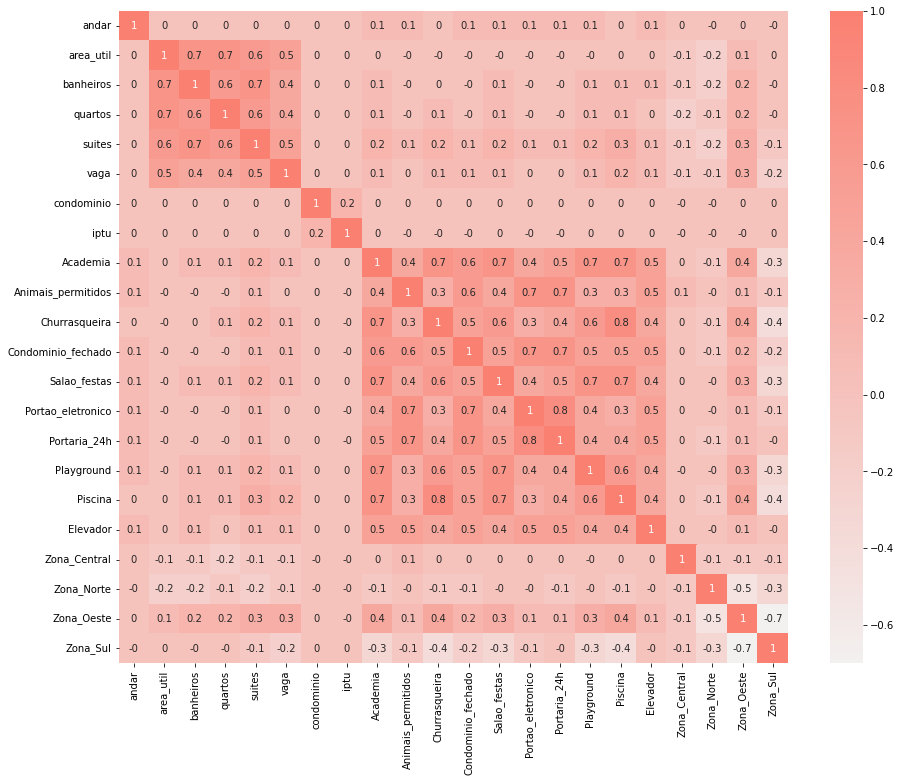

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,12))
paleta = sns.color_palette("light:salmon", as_cmap=True)
sns.heatmap(dataframe_correlacao.round(1), annot=True, cmap=paleta)

Pode-se observar que entre algumas variáveis caracteristicas existem uma coleção alta. Por exemplo, entre piscina e churrasqueira, Portaria_24h e Portao_eletronico. Outras features que existem forte correlação são banheiros e suites, quartos e area_util. 

Por enquanto vamos manter essas colunas e criar um modelo de regressão

###Criação dos modelos de machine learning


####Regressão linear

In [35]:
from pyspark.ml.regression import LinearRegression

In [40]:
treino, teste = dados_prep.randomSplit([0.7, 0.3], seed=101)#Separando dados de treino e teste
lr = LinearRegression()
modelo_lr = lr.fit(treino) # Ajuste do modelo
previsoes_lr_treino = modelo_lr.transform(treino)
resumo_treino = modelo_lr.summary
resumo_teste = modelo_lr.evaluate(teste)

In [41]:
print('Linear Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % resumo_treino.r2)
print("RMSE: %f" % resumo_treino.rootMeanSquaredError)
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % resumo_teste.r2)
print("RMSE: %f" % resumo_teste.rootMeanSquaredError)

Linear Regression
Dados de Treino
R²: 0.670036
RMSE: 839857.833205

Dados de Teste
R²: 0.655391
RMSE: 877105.361809


####Árvore de Decisão - Regressão

In [42]:
from pyspark.ml.regression import DecisionTreeRegressor

In [43]:
dtr = DecisionTreeRegressor(seed=101, maxDepth=7) # Definição do modelo de árvore de decisão com profundidade igual a 7
modelo_dtr = dtr.fit(treino) #Ajuste do modelo
previsoes_dtr_treino = modelo_dtr.transform(treino)

In [44]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator()
previsoes_dtr_teste = modelo_dtr.transform(teste)

In [45]:
print('Decision Tree Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))

Decision Tree Regression
Dados de Treino
R²: 0.797776
RMSE: 657489.229487

Dados de Teste
R²: 0.773491
RMSE: 711100.415996


####Random Forest - Regressão

In [46]:
from pyspark.ml.regression import RandomForestRegressor

In [47]:
rfr = RandomForestRegressor(seed=101, maxDepth=7, numTrees=10) # Definição de alguns imputs como profunidade e o número de árvores
modelo_rfr = rfr.fit(treino)#Ajuste do modelo
previsoes_rfr_treino = modelo_rfr.transform(treino)

In [48]:
previsoes_rfr_teste = modelo_rfr.transform(teste)

In [49]:
print('Random Forest Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))

Random Forest Regression
Dados de Treino
R²: 0.805758
RMSE: 644382.995571

Dados de Teste
R²: 0.782891
RMSE: 696189.327147


O modelo de regressão random forest apresentou os melhores resultados mas é possível melhorar os modelos por otimização de hiperparâmetros. 

###Otimização de hiperparâmetros

####Árvore de Decisão com Cross Validation

In [50]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

In [51]:
dtr = DecisionTreeRegressor()

In [52]:
grid = ParamGridBuilder() \
    .addGrid(dtr.maxDepth, [2, 5, 10])\
    .addGrid(dtr.maxBins, [10, 32, 45])\
    .build() # Definição dos hiperparametros a serem testado, 3x3, gerando 9 combinações a serem avaliadas

In [57]:
evaluator = RegressionEvaluator()
dtc_cv = CrossValidator(
    estimator=dtr,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3,
    seed = 101
    )

In [58]:
modelo_dtc_cv = dtc_cv.fit(treino)

In [61]:
previsoes_dtr_cv_teste = modelo_dtc_cv.transform(teste)

In [62]:
print('Árvore de Decisão')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "rmse"}))

Árvore de Decisão
Sem Cross Validation
R²: 0.773491
RMSE: 711100.415996

Com Cross Validation
R²: 0.787604
RMSE: 688591.204464


####Random Forest com Cross Validation

In [63]:
from pyspark.ml.regression import RandomForestRegressor
rfr = RandomForestRegressor()

In [64]:
grid = ParamGridBuilder() \
    .addGrid(rfr.numTrees, [10, 30]) \
    .addGrid(rfr.maxDepth, [5, 10]) \
    .addGrid(rfr.maxBins, [10, 45]) \
    .build() # 8 Combinações de hiperparametros

In [65]:
evaluator = RegressionEvaluator()
rfr_cv = CrossValidator(
    estimator=rfr,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3
)

In [66]:
modelo_rfr_cv = rfr_cv.fit(treino)

In [67]:
previsoes_rfr_cv_teste = modelo_rfr_cv.transform(teste)

In [68]:
print('Random Forest')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "rmse"}))

Random Forest
Sem Cross Validation
R²: 0.782891
RMSE: 696189.327147

Com Cross Validation
R²: 0.826085
RMSE: 623098.755603


###Conclusão

Foi possivel desenvolver um modelo de machine learning com coeficiente de determinação de 0,826 para predição dos valores de venda de imóveis no Rio de Janeiro. O modelo com o melhor desempenho foi o random forest utilizando cross validation.